In [15]:
# Standard libraries
import os
from pathlib import Path
import json
from typing import Dict, Any, Tuple, List

# Data / numeric
import numpy as np
import pandas as pd

# Modeling / sklearn
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Regressors
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Utilities
import joblib
import matplotlib.pyplot as plt
from scipy.stats import t
from datetime import datetime

# Matplotlib settings (publication-friendly)
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 11
})


In [16]:
# Configuration
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Paths
DATA_DIR = Path("data")
MODELS_DIR = Path("saved_models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# CV setup
OUTER_FOLDS = 5
INNER_FOLDS = 3

outer_cv = KFold(n_splits=OUTER_FOLDS, shuffle=True, random_state=RANDOM_SEED)
inner_cv = KFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# Metrics helper
METRIC_NAMES = ["RMSE", "MAE", "R2"]


In [17]:
# Load data (assumes CSV files exist at data/X_dev.csv etc.)
X = pd.read_csv(DATA_DIR / "X_dev.csv")
y = pd.read_csv(DATA_DIR / "y_dev.csv").squeeze()

X_test = pd.read_csv(DATA_DIR / "X_test.csv")
y_test = pd.read_csv(DATA_DIR / "y_test.csv").squeeze()

# Quick checks (publication should include summary statistics)
print(f"X shape: {X.shape}   y shape: {y.shape}")
print(f"X_test shape: {X_test.shape}   y_test shape: {y_test.shape}")


X shape: (76, 4)   y shape: (76,)
X_test shape: (20, 4)   y_test shape: (20,)


In [18]:
# Define estimators and param grids. For pipeline-based estimators we use 'model__' prefix.
param_grids = {
    "LinearRegression": (
        Pipeline([("scaler", StandardScaler()), ("model", LinearRegression())]),
        {}
    ),
    "Ridge": (
        Pipeline([("scaler", StandardScaler()), ("model", Ridge())]),
        {"model__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}
    ),
    "Lasso": (
        Pipeline([("scaler", StandardScaler()), ("model", Lasso(max_iter=5000))]),
        {"model__alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]}
    ),
    "ElasticNet": (
        Pipeline([("scaler", StandardScaler()), ("model", ElasticNet(max_iter=5000))]),
        {
            "model__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1],
            "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
        }
    ),

    # Tree-based models (no scaler)
    "DecisionTree": (
        DecisionTreeRegressor(random_state=RANDOM_SEED),
        {"max_depth": [3, 5, 7, 10, None], "min_samples_split": [2, 5, 10], "min_samples_leaf": [1, 2, 4]}
    ),

    "RandomForest": (
        RandomForestRegressor(random_state=RANDOM_SEED),
        {
            "n_estimators": [100, 200],
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "max_features": ["sqrt", "log2"]
        }
    ),

    "GradientBoosting": (
        GradientBoostingRegressor(random_state=RANDOM_SEED),
        {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    ),

    "AdaBoost": (
        AdaBoostRegressor(random_state=RANDOM_SEED),
        {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.05, 0.1]}
    ),

    "KNN": (
        Pipeline([("scaler", StandardScaler()), ("model", KNeighborsRegressor())]),
        {"model__n_neighbors": [3, 5, 7], "model__weights": ["uniform", "distance"], "model__p": [1, 2]}
    ),

    "MLP": (
        Pipeline([("scaler", StandardScaler()), ("model", MLPRegressor(random_state=RANDOM_SEED, max_iter=2000))]),
        {
            "model__hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "model__activation": ["relu", "tanh"],
            "model__alpha": [1e-4, 1e-3],
            "model__learning_rate": ["constant", "adaptive"]
        }
    ),

    "XGBoost": (
        XGBRegressor(random_state=RANDOM_SEED, objective="reg:squarederror"),
        {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }
    )
}


In [19]:
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """Return RMSE, MAE, R2."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

def t_confidence_interval(values: np.ndarray, confidence: float = 0.95) -> Tuple[float, float]:
    """Compute t-distribution 2-sided CI for the mean of `values`."""
    n = len(values)
    mean = float(np.mean(values))
    if n <= 1:
        return mean, mean
    std = float(np.std(values, ddof=1))
    t_val = t.ppf(1 - (1 - confidence) / 2, df=n - 1)
    margin = t_val * (std / np.sqrt(n))
    return mean - margin, mean + margin

def format_mean_std_ci(values: np.ndarray) -> str:
    mean = float(np.mean(values))
    std = float(np.std(values, ddof=1))
    low, high = t_confidence_interval(values)
    return f"{mean:.3f} ± {std:.3f} (95% CI [{low:.3f}, {high:.3f}])"

def ensure_dir(path: Path):
    path.mkdir(parents=True, exist_ok=True)


In [20]:
def nested_cv_with_plots(
    X: pd.DataFrame,
    y: pd.Series,
    model_name: str,
    estimator,
    param_grid: dict,
    outer_cv,
    inner_cv,
    scoring: str = "neg_root_mean_squared_error",
    n_jobs: int = -1
) -> Dict[str, Any]:
    """
    Run nested CV: for each outer fold, run GridSearchCV on inner_cv, fit best on train, evaluate on both train & val.
    Returns a dict with fold-level metrics, best-params per outer fold, and concatenated predictions for plotting.
    """
    results = {
        "best_params_per_fold": [],
        "train_metrics": [],
        "val_metrics": [],
        "train_preds": [],  # tuple (y_true, y_pred)
        "val_preds": []
    }

    # We'll remember global min/max across all y & predictions to set equal plotting axes
    global_min, global_max = float("inf"), float("-inf")

    for fold_num, (train_idx, val_idx) in enumerate(outer_cv.split(X), start=1):
        print(f"[{model_name}] Outer fold {fold_num}/{outer_cv.get_n_splits()} ...")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        grid = GridSearchCV(
            estimator=estimator,
            param_grid=param_grid,
            scoring=scoring,
            cv=inner_cv,
            n_jobs=n_jobs,
            refit=True
        )
        grid.fit(X_train, y_train)

        best = grid.best_estimator_
        best_params = grid.best_params_
        results["best_params_per_fold"].append(best_params)

        # Fit best estimator on the outer training set (refit=True already done, but ensure)
        best.fit(X_train, y_train)

        y_train_pred = best.predict(X_train)
        y_val_pred = best.predict(X_val)

        # metrics
        results["train_metrics"].append(pd.Series(compute_metrics(y_train, y_train_pred)))
        results["val_metrics"].append(pd.Series(compute_metrics(y_val, y_val_pred)))

        results["train_preds"].append((y_train.values, y_train_pred))
        results["val_preds"].append((y_val.values, y_val_pred))

        # update global min/max
        for arr in (y_train.values, y_train_pred, y_val.values, y_val_pred):
            global_min = min(global_min, float(np.min(arr)))
            global_max = max(global_max, float(np.max(arr)))

    # Create plots: combined scatter plot for train and val across folds (one figure)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    for fold_idx, (y_true, y_pred) in enumerate(results["train_preds"], start=1):
        axes[0].scatter(y_true, y_pred, alpha=0.35, label=f"Fold {fold_idx}")
    axes[0].plot([global_min, global_max], [global_min, global_max], "r--", linewidth=1)
    axes[0].set_title(f"{model_name} — Training (outer folds)")
    axes[0].set_xlabel("Actual Fiber Diameter (nm)")
    axes[0].set_ylabel("Predicted Fiber Diameter (nm)")
    axes[0].grid(True)
    axes[0].legend(fontsize="small")

    for fold_idx, (y_true, y_pred) in enumerate(results["val_preds"], start=1):
        axes[1].scatter(y_true, y_pred, alpha=0.45, label=f"Fold {fold_idx}")
    axes[1].plot([global_min, global_max], [global_min, global_max], "r--", linewidth=1)
    axes[1].set_title(f"{model_name} — Validation (outer folds)")
    axes[1].set_xlabel("Actual Fiber Diameter (nm)")

    axes[1].grid(True)
    axes[1].legend(fontsize="small")

    plt.tight_layout()
    plt.show()

    # Convert lists of Series to DataFrame (rows=folds)
    train_metrics_df = pd.DataFrame(results["train_metrics"]).reset_index(drop=True)
    val_metrics_df = pd.DataFrame(results["val_metrics"]).reset_index(drop=True)

    return {
        "model_name": model_name,
        "best_params_per_fold": results["best_params_per_fold"],
        "train_metrics_df": train_metrics_df,
        "val_metrics_df": val_metrics_df
    }



############################################################
Starting nested CV for: LinearRegression
[LinearRegression] Outer fold 1/5 ...
[LinearRegression] Outer fold 2/5 ...
[LinearRegression] Outer fold 3/5 ...
[LinearRegression] Outer fold 4/5 ...
[LinearRegression] Outer fold 5/5 ...


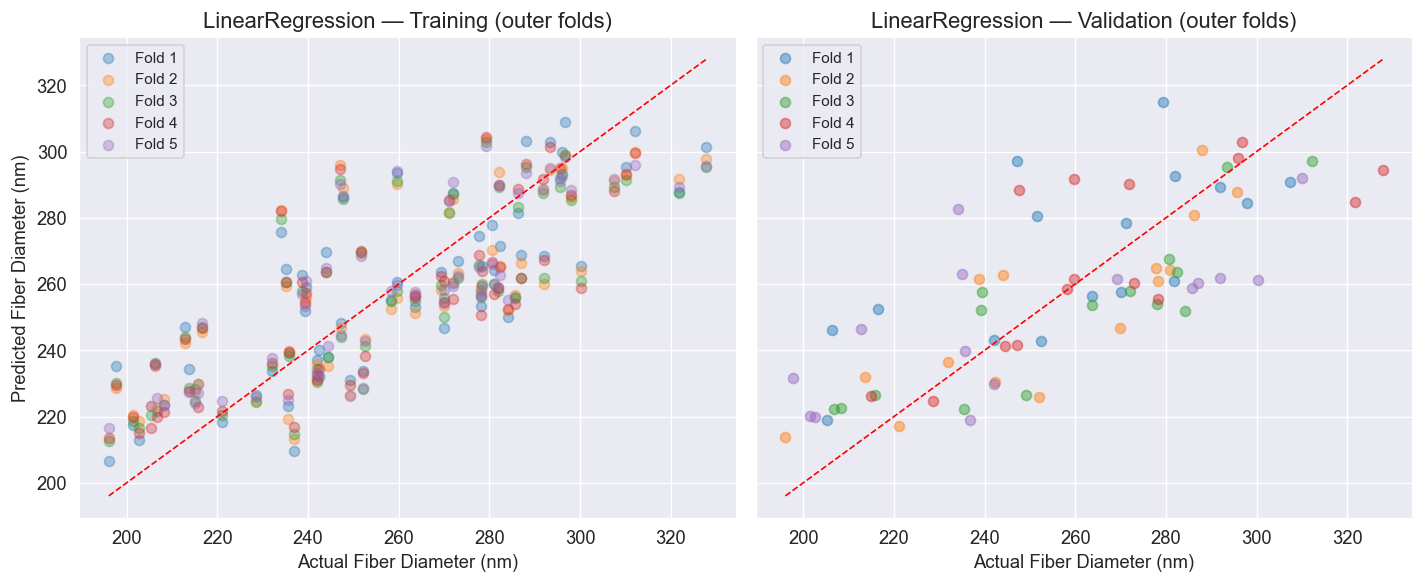

Done: LinearRegression — best params per fold: [{}, {}, {}, {}, {}]


############################################################
Starting nested CV for: Ridge
[Ridge] Outer fold 1/5 ...
[Ridge] Outer fold 2/5 ...
[Ridge] Outer fold 3/5 ...
[Ridge] Outer fold 4/5 ...
[Ridge] Outer fold 5/5 ...


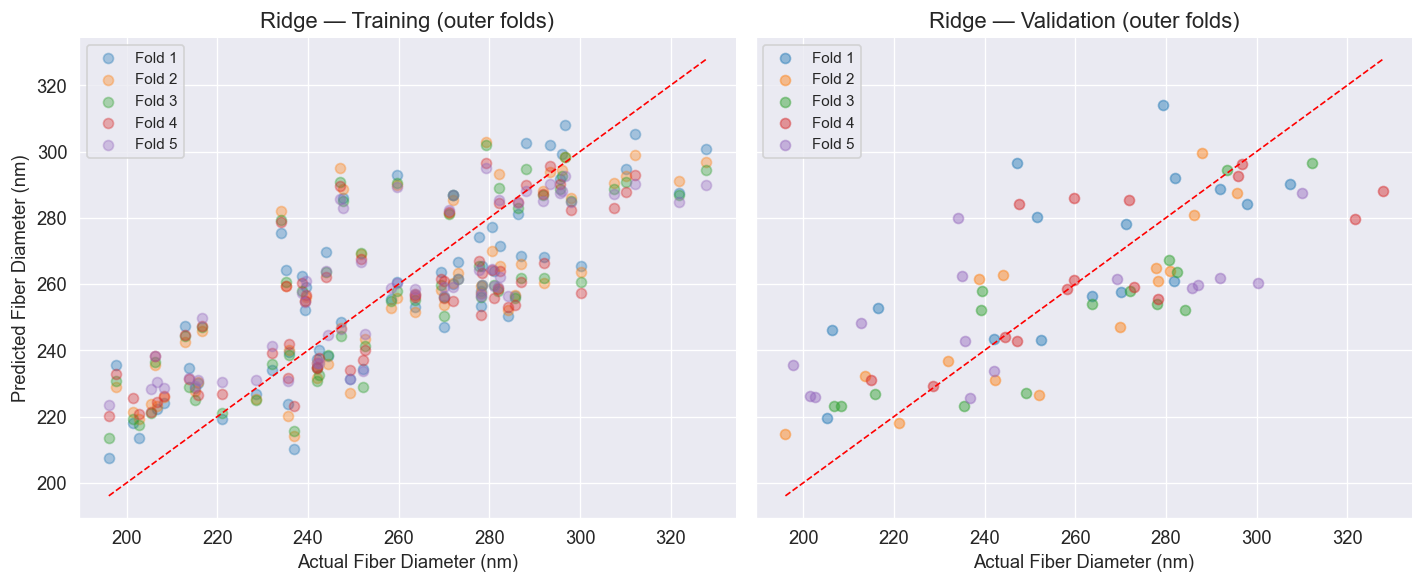

Done: Ridge — best params per fold: [{'model__alpha': 1}, {'model__alpha': 1}, {'model__alpha': 1}, {'model__alpha': 10}, {'model__alpha': 10}]


############################################################
Starting nested CV for: Lasso
[Lasso] Outer fold 1/5 ...
[Lasso] Outer fold 2/5 ...
[Lasso] Outer fold 3/5 ...
[Lasso] Outer fold 4/5 ...
[Lasso] Outer fold 5/5 ...


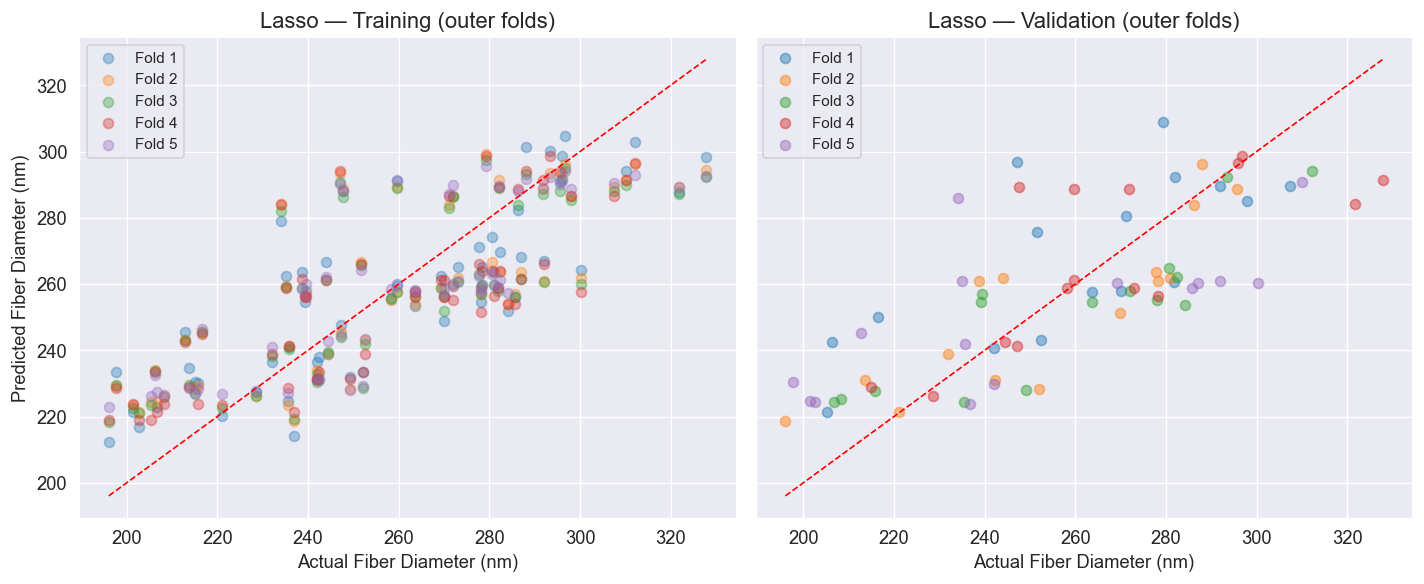

Done: Lasso — best params per fold: [{'model__alpha': 1}, {'model__alpha': 1}, {'model__alpha': 1}, {'model__alpha': 1}, {'model__alpha': 1}]


############################################################
Starting nested CV for: ElasticNet
[ElasticNet] Outer fold 1/5 ...
[ElasticNet] Outer fold 2/5 ...
[ElasticNet] Outer fold 3/5 ...
[ElasticNet] Outer fold 4/5 ...
[ElasticNet] Outer fold 5/5 ...


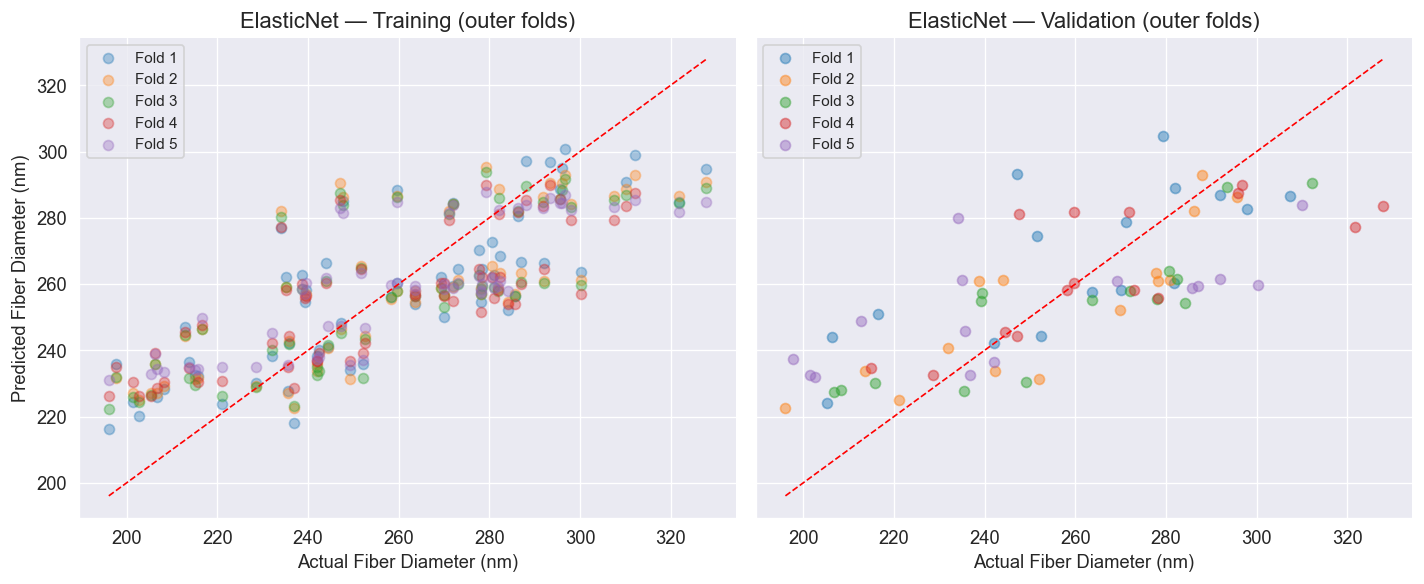

Done: ElasticNet — best params per fold: [{'model__alpha': 1, 'model__l1_ratio': 0.9}, {'model__alpha': 1, 'model__l1_ratio': 0.9}, {'model__alpha': 1, 'model__l1_ratio': 0.9}, {'model__alpha': 1, 'model__l1_ratio': 0.7}, {'model__alpha': 1, 'model__l1_ratio': 0.7}]


############################################################
Starting nested CV for: DecisionTree
[DecisionTree] Outer fold 1/5 ...
[DecisionTree] Outer fold 2/5 ...
[DecisionTree] Outer fold 3/5 ...
[DecisionTree] Outer fold 4/5 ...
[DecisionTree] Outer fold 5/5 ...


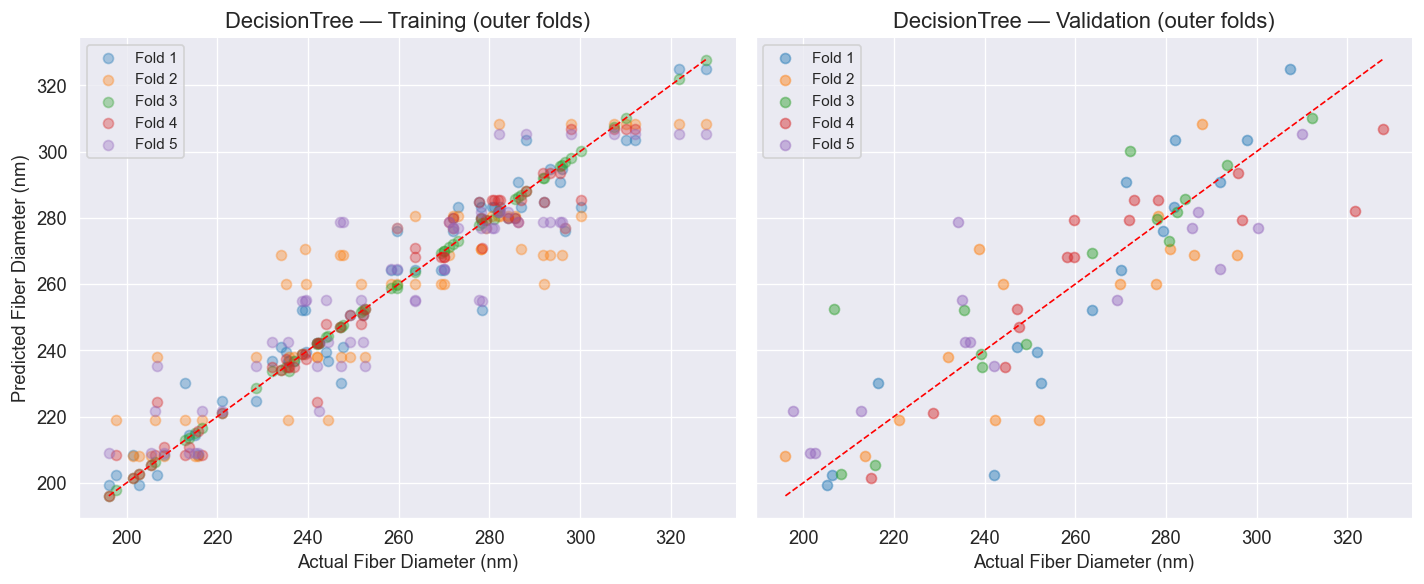

Done: DecisionTree — best params per fold: [{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}, {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}, {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}, {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}, {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}]


############################################################
Starting nested CV for: RandomForest
[RandomForest] Outer fold 1/5 ...
[RandomForest] Outer fold 2/5 ...
[RandomForest] Outer fold 3/5 ...
[RandomForest] Outer fold 4/5 ...
[RandomForest] Outer fold 5/5 ...


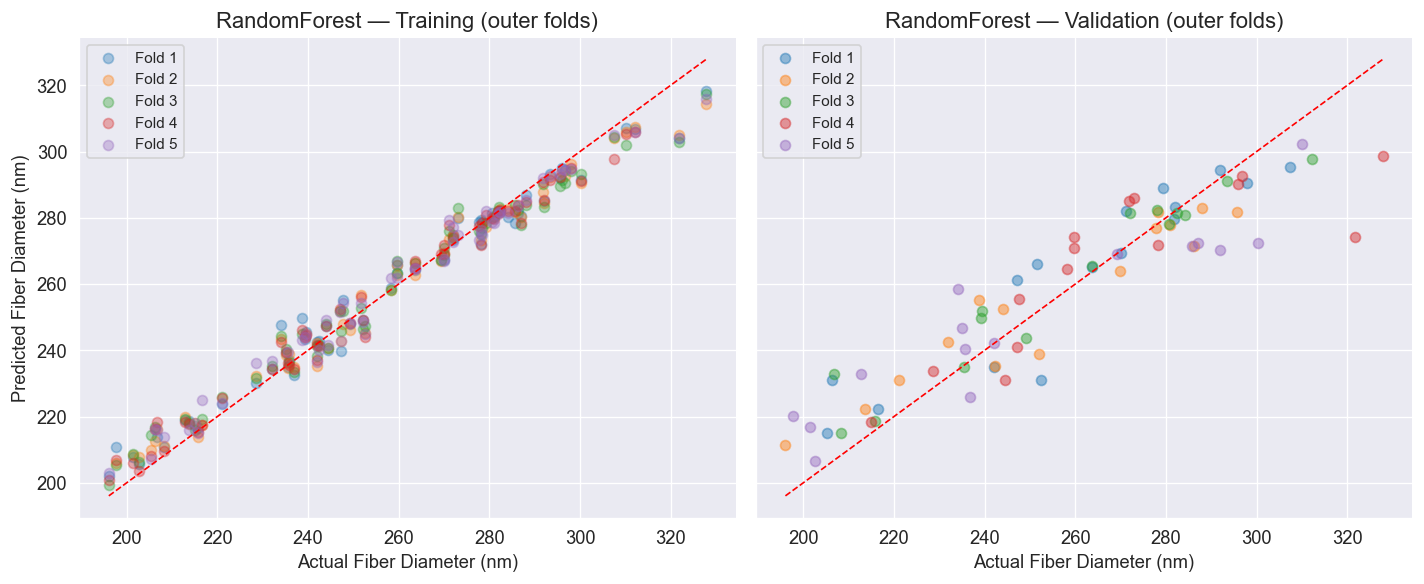

Done: RandomForest — best params per fold: [{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}]


############################################################
Starting nested CV for: GradientBoosting
[GradientBoosting] Outer fold 1/5 ...
[GradientBoosting] Outer fold 2/5 ...
[GradientBoosting] Outer fold 3/5 ...
[GradientBoosting] Outer fold 4/5 ...
[GradientBoosting] Outer fold 5/5 ...


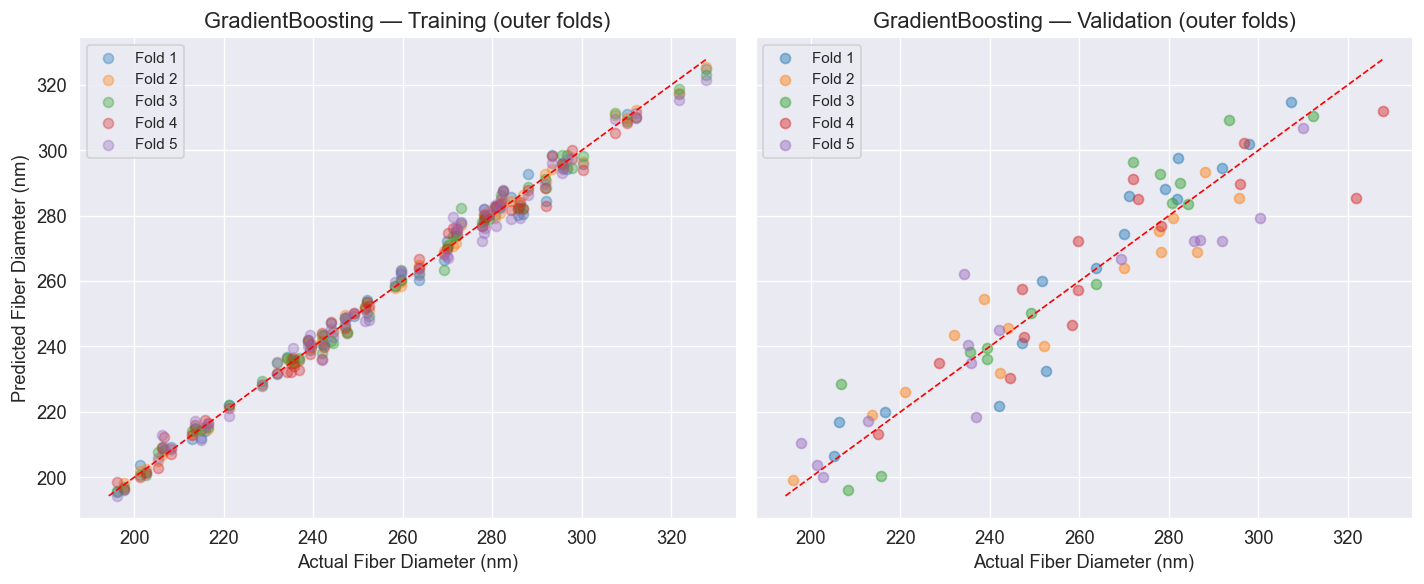

Done: GradientBoosting — best params per fold: [{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}, {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}, {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}, {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}, {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}]


############################################################
Starting nested CV for: AdaBoost
[AdaBoost] Outer fold 1/5 ...
[AdaBoost] Outer fold 2/5 ...
[AdaBoost] Outer fold 3/5 ...
[AdaBoost] Outer fold 4/5 ...
[AdaBoost] Outer fold 5/5 ...


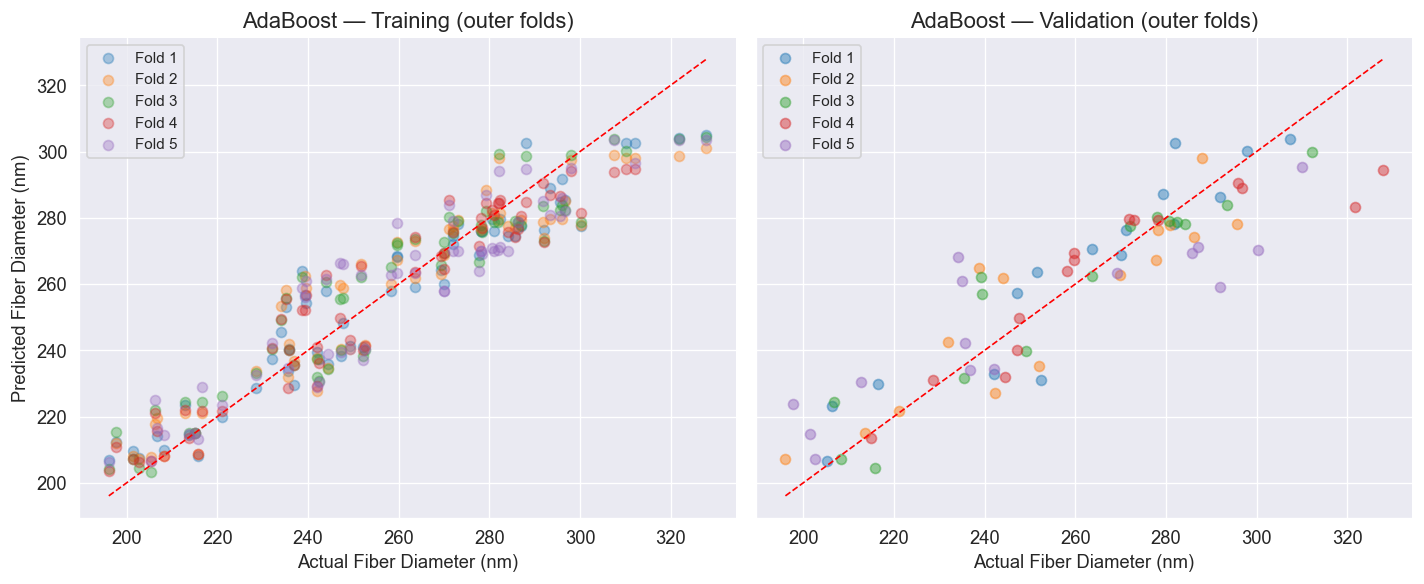

Done: AdaBoost — best params per fold: [{'learning_rate': 0.1, 'n_estimators': 200}, {'learning_rate': 0.1, 'n_estimators': 100}, {'learning_rate': 0.1, 'n_estimators': 200}, {'learning_rate': 0.1, 'n_estimators': 200}, {'learning_rate': 0.1, 'n_estimators': 200}]


############################################################
Starting nested CV for: KNN
[KNN] Outer fold 1/5 ...
[KNN] Outer fold 2/5 ...
[KNN] Outer fold 3/5 ...
[KNN] Outer fold 4/5 ...
[KNN] Outer fold 5/5 ...


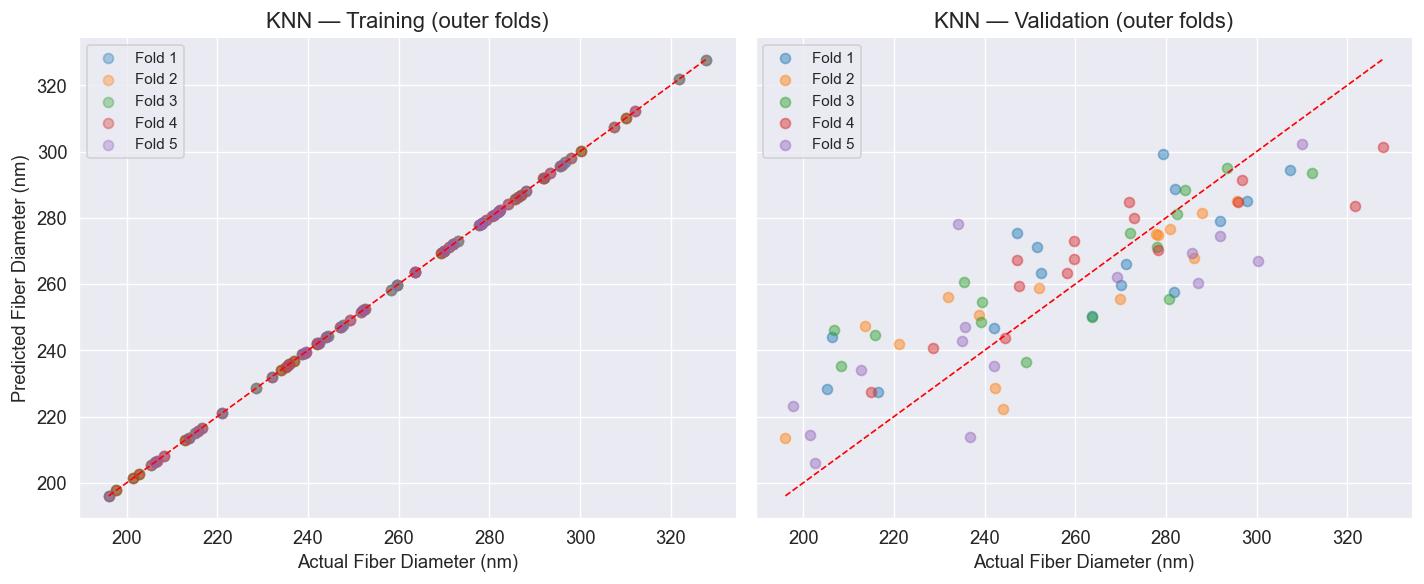

Done: KNN — best params per fold: [{'model__n_neighbors': 5, 'model__p': 2, 'model__weights': 'distance'}, {'model__n_neighbors': 3, 'model__p': 2, 'model__weights': 'distance'}, {'model__n_neighbors': 3, 'model__p': 1, 'model__weights': 'distance'}, {'model__n_neighbors': 5, 'model__p': 1, 'model__weights': 'distance'}, {'model__n_neighbors': 5, 'model__p': 1, 'model__weights': 'distance'}]


############################################################
Starting nested CV for: MLP
[MLP] Outer fold 1/5 ...


/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: Conv

[MLP] Outer fold 2/5 ...


/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: Conv

[MLP] Outer fold 3/5 ...


/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: Conv

[MLP] Outer fold 4/5 ...


/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: Conv

[MLP] Outer fold 5/5 ...


/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: Conv

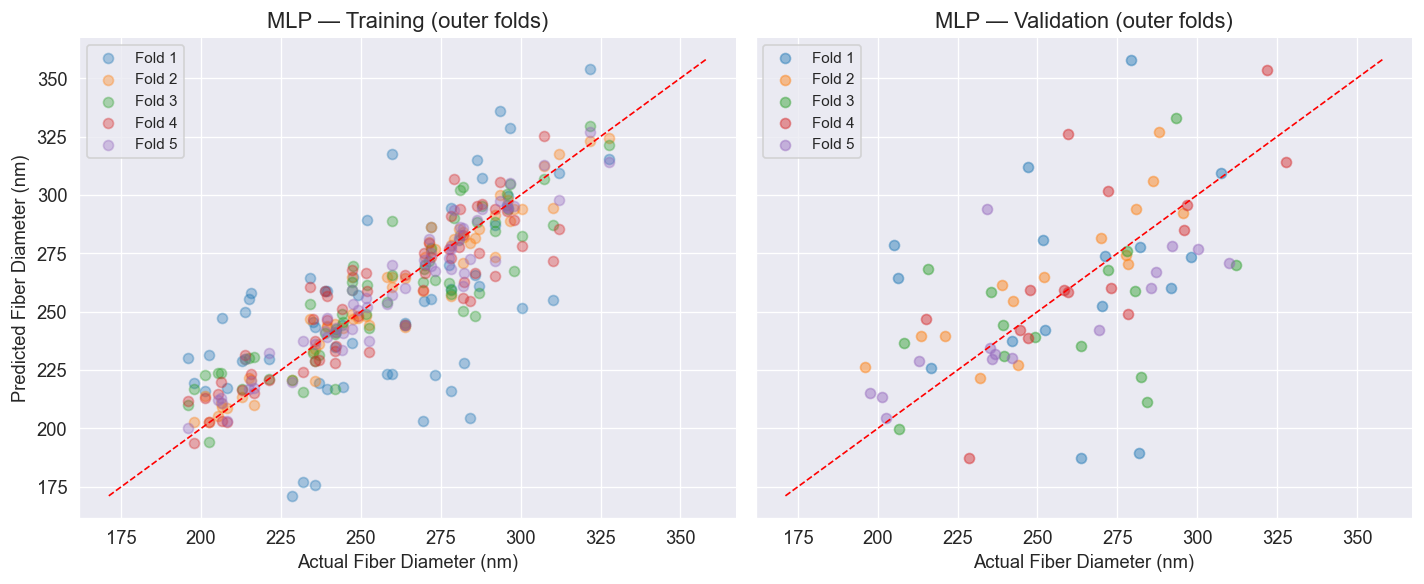

Done: MLP — best params per fold: [{'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (100,), 'model__learning_rate': 'constant'}, {'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (50, 50), 'model__learning_rate': 'constant'}, {'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (50, 50), 'model__learning_rate': 'constant'}, {'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (50, 50), 'model__learning_rate': 'constant'}, {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (50, 50), 'model__learning_rate': 'constant'}]


############################################################
Starting nested CV for: XGBoost
[XGBoost] Outer fold 1/5 ...
[XGBoost] Outer fold 2/5 ...
[XGBoost] Outer fold 3/5 ...
[XGBoost] Outer fold 4/5 ...
[XGBoost] Outer fold 5/5 ...


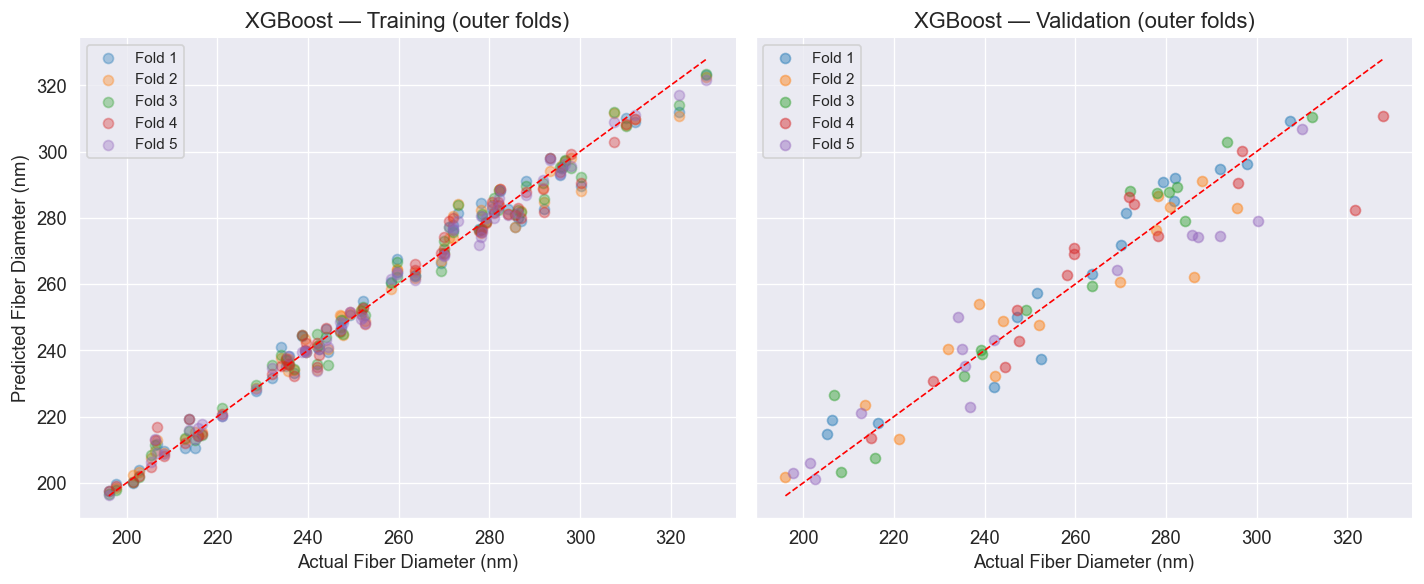

Done: XGBoost — best params per fold: [{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}, {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}, {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}, {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}, {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}]



In [21]:
all_results = {}

for model_name, (estimator, param_grid) in param_grids.items():
    print("\n" + "#" * 60)
    print(f"Starting nested CV for: {model_name}")
    res = nested_cv_with_plots(
        X=X,
        y=y,
        model_name=model_name,
        estimator=estimator,
        param_grid=param_grid,
        outer_cv=outer_cv,
        inner_cv=inner_cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )
    all_results[model_name] = res
    print(f"Done: {model_name} — best params per fold: {res['best_params_per_fold']}\n")


In [22]:
# Build a summary DataFrame with means, stds, and 95% CI for each metric and dataset (train/val)
summary_rows = []
for model_name, res in all_results.items():
    train_df = res["train_metrics_df"]
    val_df = res["val_metrics_df"]

    row = {"Model": model_name}
    for prefix, df in [("Train", train_df), ("Val", val_df)]:
        for metric in ["RMSE", "MAE", "R2"]:
            arr = df[metric].values
            mean = np.mean(arr)
            std = np.std(arr, ddof=1) if len(arr) > 1 else 0.0
            ci_low, ci_high = t_confidence_interval(arr)
            row[f"{metric}_{prefix}_Mean"] = mean
            row[f"{metric}_{prefix}_Std"] = std
            row[f"{metric}_{prefix}_CI_Low"] = ci_low
            row[f"{metric}_{prefix}_CI_High"] = ci_high
            row[f"{metric}_{prefix}_Display"] = f"{mean:.3f} ± {std:.3f} (95% CI [{ci_low:.3f}, {ci_high:.3f}])"
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).set_index("Model")
# Sort by validation RMSE mean (best -> worst)
summary_df = summary_df.sort_values("RMSE_Val_Mean")
summary_df


,RMSE_Train_Mean,RMSE_Train_Std,RMSE_Train_CI_Low,RMSE_Train_CI_High,RMSE_Train_Display,MAE_Train_Mean,MAE_Train_Std,MAE_Train_CI_Low,MAE_Train_CI_High,MAE_Train_Display,...,MAE_Val_Mean,MAE_Val_Std,MAE_Val_CI_Low,MAE_Val_CI_High,MAE_Val_Display,R2_Val_Mean,R2_Val_Std,R2_Val_CI_Low,R2_Val_CI_High,R2_Val_Display
Model,,,,,,,,,,,,,,,,,,,,,
XGBoost,3.911694,0.434770,3.371855,4.451533,"3.912 ± 0.435 (95% CI [3.372, 4.452])",2.981284,0.273769,2.641355,3.321213,"2.981 ± 0.274 (95% CI [2.641, 3.321])",...,7.945373,1.286509,6.347960,9.542785,"7.945 ± 1.287 (95% CI [6.348, 9.543])",0.893887,0.047701,0.834658,0.953116,"0.894 ± 0.048 (95% CI [0.835, 0.953])"
GradientBoosting,2.644819,0.675889,1.805592,3.484046,"2.645 ± 0.676 (95% CI [1.806, 3.484])",2.075808,0.584556,1.349986,2.801630,"2.076 ± 0.585 (95% CI [1.350, 2.802])",...,9.077920,1.276596,7.492817,10.663023,"9.078 ± 1.277 (95% CI [7.493, 10.663])",0.864954,0.039319,0.816133,0.913775,"0.865 ± 0.039 (95% CI [0.816, 0.914])"
RandomForest,5.208794,0.357947,4.764344,5.653244,"5.209 ± 0.358 (95% CI [4.764, 5.653])",4.055851,0.284213,3.702953,4.408748,"4.056 ± 0.284 (95% CI [3.703, 4.409])",...,10.185569,2.650774,6.894198,13.476940,"10.186 ± 2.651 (95% CI [6.894, 13.477])",0.832617,0.080244,0.732980,0.932253,"0.833 ± 0.080 (95% CI [0.733, 0.932])"
AdaBoost,10.710072,0.874153,9.624667,11.795476,"10.710 ± 0.874 (95% CI [9.625, 11.795])",8.812898,0.971178,7.607021,10.018776,"8.813 ± 0.971 (95% CI [7.607, 10.019])",...,10.960773,3.479696,6.640160,15.281386,"10.961 ± 3.480 (95% CI [6.640, 15.281])",0.811691,0.070597,0.724033,0.899349,"0.812 ± 0.071 (95% CI [0.724, 0.899])"
DecisionTree,8.430044,5.903623,1.099728,15.760360,"8.430 ± 5.904 (95% CI [1.100, 15.760])",6.337632,4.802921,0.374019,12.301246,"6.338 ± 4.803 (95% CI [0.374, 12.301])",...,12.672472,2.423863,9.662849,15.682096,"12.672 ± 2.424 (95% CI [9.663, 15.682])",0.725198,0.065419,0.643970,0.806427,"0.725 ± 0.065 (95% CI [0.644, 0.806])"
KNN,0.000000,0.000000,0.000000,0.000000,"0.000 ± 0.000 (95% CI [0.000, 0.000])",0.000000,0.000000,0.000000,0.000000,"0.000 ± 0.000 (95% CI [0.000, 0.000])",...,15.167452,1.840781,12.881821,17.453084,"15.167 ± 1.841 (95% CI [12.882, 17.453])",0.677598,0.044389,0.622482,0.732714,"0.678 ± 0.044 (95% CI [0.622, 0.733])"
Lasso,19.890268,1.143638,18.470254,21.310282,"19.890 ± 1.144 (95% CI [18.470, 21.310])",16.754869,1.056749,15.442741,18.066996,"16.755 ± 1.057 (95% CI [15.443, 18.067])",...,17.668863,4.315773,12.310123,23.027603,"17.669 ± 4.316 (95% CI [12.310, 23.028])",0.570053,0.127912,0.411229,0.728877,"0.570 ± 0.128 (95% CI [0.411, 0.729])"
LinearRegression,19.778015,1.156491,18.342042,21.213989,"19.778 ± 1.156 (95% CI [18.342, 21.214])",16.559536,1.115929,15.173927,17.945144,"16.560 ± 1.116 (95% CI [15.174, 17.945])",...,17.823694,3.948208,12.921347,22.726042,"17.824 ± 3.948 (95% CI [12.921, 22.726])",0.561831,0.140347,0.387567,0.736096,"0.562 ± 0.140 (95% CI [0.388, 0.736])"
Ridge,19.921043,1.040096,18.629593,21.212492,"19.921 ± 1.040 (95% CI [18.630, 21.212])",16.723018,1.037821,15.434393,18.011643,"16.723 ± 1.038 (95% CI [15.434, 18.012])",...,17.869872,4.387414,12.422177,23.317566,"17.870 ± 4.387 (95% CI [12.422, 23.318])",0.554780,0.144057,0.375911,0.733650,"0.555 ± 0.144 (95% CI [0.376, 0.734])"


In [23]:
# Tabulate best params per fold for each model
best_params_table = {
    model: {"best_params_per_fold": all_results[model]["best_params_per_fold"]}
    for model in all_results
}

# Save JSON for reproducibility
with open(MODELS_DIR / "best_params_per_model.json", "w") as f:
    json.dump(best_params_table, f, indent=2, default=str)

print(f"Saved best-params-per-fold JSON to {MODELS_DIR / 'best_params_per_model.json'}")


Saved best-params-per-fold JSON to saved_models/best_params_per_model.json


In [24]:
final_results = {}
trained_models = {}

for model_name, (estimator, param_grid) in param_grids.items():
    print("\n" + "-" * 80)
    print(f"Final training on full training data: {model_name}")

    # Run grid search on full training data (5-fold CV)
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1, refit=True)
    grid.fit(X, y)

    best = grid.best_estimator_
    best_params = grid.best_params_
    print("Best params (grid on full training set):", best_params)

    # Evaluate on test set
    y_test_pred = best.predict(X_test)
    metrics = compute_metrics(y_test, y_test_pred)
    print(f"Test RMSE: {metrics['RMSE']:.4f}   MAE: {metrics['MAE']:.4f}   R2: {metrics['R2']:.4f}")

    # Save
    safe_name = model_name.replace(" ", "_")
    model_path = MODELS_DIR / f"{safe_name}_model.pkl"
    joblib.dump(best, model_path)

    final_results[model_name] = {
        "Best_Params": best_params,
        "RMSE_Test": metrics["RMSE"],
        "MAE_Test": metrics["MAE"],
        "R2_Test": metrics["R2"],
        "Saved_Path": str(model_path)
    }
    trained_models[model_name] = best

# Final results DataFrame
final_results_df = pd.DataFrame(final_results).T.sort_values("RMSE_Test")
final_results_df



--------------------------------------------------------------------------------
Final training on full training data: LinearRegression
Best params (grid on full training set): {}
Test RMSE: 20.5197   MAE: 15.6435   R2: 0.7476

--------------------------------------------------------------------------------
Final training on full training data: Ridge
Best params (grid on full training set): {'model__alpha': 1}
Test RMSE: 20.6774   MAE: 15.6530   R2: 0.7437

--------------------------------------------------------------------------------
Final training on full training data: Lasso
Best params (grid on full training set): {'model__alpha': 0.01}
Test RMSE: 20.5281   MAE: 15.6440   R2: 0.7474

--------------------------------------------------------------------------------
Final training on full training data: ElasticNet
Best params (grid on full training set): {'model__alpha': 0.01, 'model__l1_ratio': 0.1}
Test RMSE: 20.6281   MAE: 15.6501   R2: 0.7449

----------------------------------

/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: Conv

Best params (grid on full training set): {'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (50, 50), 'model__learning_rate': 'constant'}
Test RMSE: 15.8839   MAE: 12.8526   R2: 0.8487

--------------------------------------------------------------------------------
Final training on full training data: XGBoost
Best params (grid on full training set): {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Test RMSE: 13.5568   MAE: 11.1600   R2: 0.8898


,Best_Params,RMSE_Test,MAE_Test,R2_Test,Saved_Path
XGBoost,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",13.556843,11.159955,0.889818,saved_models/XGBoost_model.pkl
GradientBoosting,"{'learning_rate': 0.05, 'max_depth': 3, 'min_s...",14.840674,12.16527,0.867961,saved_models/GradientBoosting_model.pkl
MLP,"{'model__activation': 'relu', 'model__alpha': ...",15.88385,12.852616,0.848746,saved_models/MLP_model.pkl
DecisionTree,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",16.385819,13.5288,0.839035,saved_models/DecisionTree_model.pkl
RandomForest,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",20.071046,15.00204,0.75849,saved_models/RandomForest_model.pkl
KNN,"{'model__n_neighbors': 5, 'model__p': 1, 'mode...",20.323665,14.633441,0.752372,saved_models/KNN_model.pkl
LinearRegression,{},20.519697,15.643496,0.747572,saved_models/LinearRegression_model.pkl
Lasso,{'model__alpha': 0.01},20.528081,15.644026,0.747366,saved_models/Lasso_model.pkl
ElasticNet,"{'model__alpha': 0.01, 'model__l1_ratio': 0.1}",20.628113,15.650075,0.744898,saved_models/ElasticNet_model.pkl
Ridge,{'model__alpha': 1},20.6774,15.653042,0.743677,saved_models/Ridge_model.pkl


Best model on test set: XGBoost


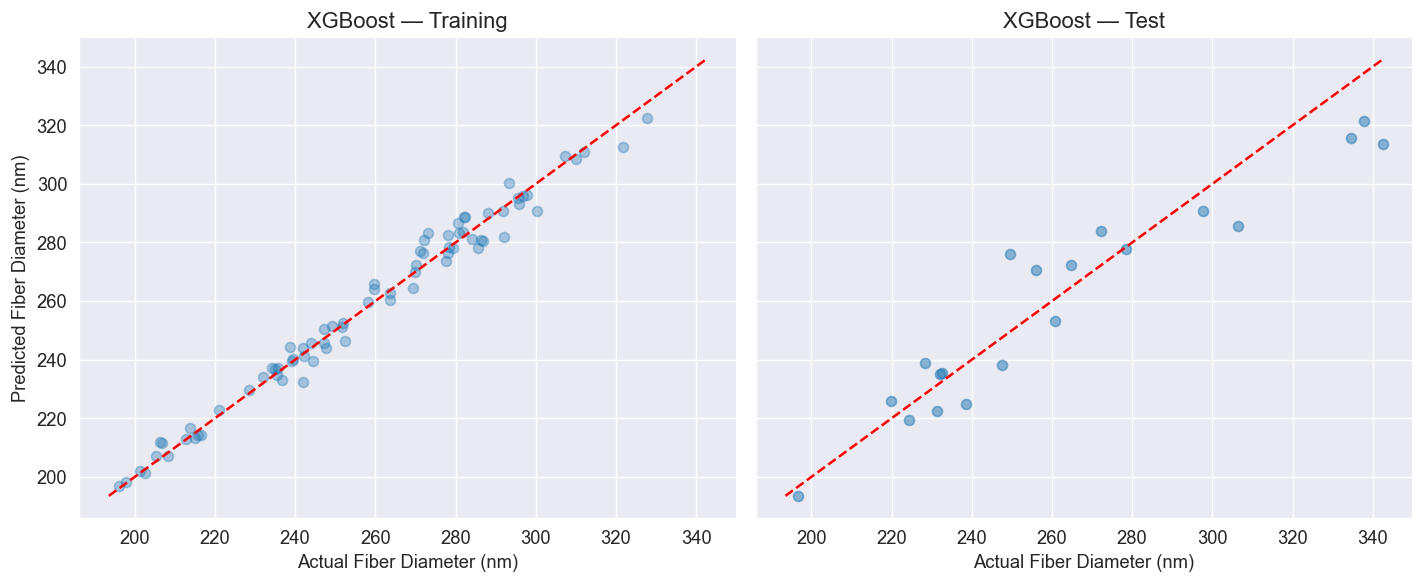

In [27]:
# Choose the best model by test RMSE
best_model_name = final_results_df.index[0]
print("Best model on test set:", best_model_name)

best_model = trained_models[best_model_name]

# Predictions
y_train_pred = best_model.predict(X)
y_test_pred = best_model.predict(X_test)

global_min = min(y.min(), y_train_pred.min(), y_test.min(), y_test_pred.min())
global_max = max(y.max(), y_train_pred.max(), y_test.max(), y_test_pred.max())

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
axes[0].scatter(y, y_train_pred, alpha=0.35)
axes[0].plot([global_min, global_max], [global_min, global_max], "r--")
axes[0].set_title(f"{best_model_name} — Training")
axes[0].set_xlabel("Actual Fiber Diameter (nm)")
axes[0].set_ylabel("Predicted Fiber Diameter (nm)")
axes[0].grid(True)

axes[1].scatter(y_test, y_test_pred, alpha=0.5)
axes[1].plot([global_min, global_max], [global_min, global_max], "r--")
axes[1].set_title(f"{best_model_name} — Test")
axes[1].set_xlabel("Actual Fiber Diameter (nm)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [26]:
# Save summary tables
summary_df.to_csv(MODELS_DIR / "nested_cv_summary.csv")
final_results_df.to_csv(MODELS_DIR / "final_test_results.csv")

print("Saved summary CSVs to", MODELS_DIR.resolve())
print("\nTop 3 models by test RMSE:")
print(final_results_df.head(3))


Saved summary CSVs to /Users/mehrabmahdian/projects/cogni-e-spin-inverse-design/main/saved_models

Top 3 models by test RMSE:
                                                        Best_Params  \
XGBoost           {'colsample_bytree': 1.0, 'learning_rate': 0.0...   
GradientBoosting  {'learning_rate': 0.05, 'max_depth': 3, 'min_s...   
MLP               {'model__activation': 'relu', 'model__alpha': ...   

                  RMSE_Test   MAE_Test   R2_Test  \
XGBoost           13.556843  11.159955  0.889818   
GradientBoosting  14.840674   12.16527  0.867961   
MLP                15.88385  12.852616  0.848746   

                                               Saved_Path  
XGBoost                    saved_models/XGBoost_model.pkl  
GradientBoosting  saved_models/GradientBoosting_model.pkl  
MLP                            saved_models/MLP_model.pkl  
